# ResNet: Tensorflow Train

Because we train our model with an unbalanced dataset, it's recommended to use F1 Score as the metric to assess our models quality. 

With this in mind, we will re-train our ResNet18 using F1 Score instead of accuracy.

### Initialize Notebook & packages

In [2]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-18 23:40:12.467778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 23:40:12.482128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 23:40:12.486573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 23:40:12.497549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.6.0

End checks and initialization.


I0000 00:00:1734565214.449484  878837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734565214.488722  878837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734565214.492185  878837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734565214.497363  878837 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.metrics import F1Score, AUC
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

### Clear GPU memory

In [3]:
import tensorflow as tf
from keras import backend as K

# Clear TensorFlow session and reset the graph
K.clear_session()
tf.compat.v1.reset_default_graph()

## IMPORT DATA

### Train, validation and test split 

In [4]:
images_dir = '../../../IMC_images' 
metadata_dir = '../../../metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir

# Load the CSV
df = pd.read_csv(csv_file)

# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)

# --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])


### Import function for dataset

In [6]:

# --- Load Images and Compute Mean and Standard Deviation ---
# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)

# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))

# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2

# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)

# --- Dataset Loading Function ---

def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)

        if normalize:
            image = (image - mean) / std # Z-Score

        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))

        # # Apply data augmentation if specified
        # if augment:
        #     # Random horizontal flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=2)
        #     # Random vertical flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=1)

        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)

## ResNet18: with Tensor Board + 46 Channels + with Dropout + ReduceLR + EarlyStopping + sigmoid instead of softmax + 1 neuron instead of 

Adjust the last classificaiton layer to contain 1 neuron and the sigmoid activation function (instead of 2 neurons and the softmax), because this is more suited for binary classificaiton. Model retrained underneath

### Create Datasets: Disable one-hot encoding for sigmoid / F1-Score

In [7]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

# #  Disable for F1_score / Sigmoid 
# # One Hot Encoding
# y_train= to_categorical(y_train)
# y_val= to_categorical(y_val)
# y_test = to_categorical(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (590, 224, 224, 46), y_train shape: (590,)
X_val shape: (197, 224, 224, 46), y_val shape: (197,)
X_test shape: (197, 224, 224, 46), y_test shape: (197,)


### ResNet18: with Tensor Board + 46 Channels + with Dropout + ReduceLR + EarlyStopping + sigmoid (1 neuron) + binary cross entropy

Redefine Model Architecture

Classification layer: 1 neuron + simgoid activation function (not one-hot encoded labels)

In [ ]:
def identity_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet(shape = (32, 32, 3), classes = 10, block_layers = [3, 4, 6, 3], dropout_rate = 0.5):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = block_layers
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x) # Change last layer here: sigmoid and 1 neuron (classes -1)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet18")
    return model

### Callbacks 

In [ ]:
# Callbacks

log_dir = os.path.join("logs_ResNet50", "fit", "model_ResNet18_46_dropout_callbacks_sigmoid_trained" + time.strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,   # Optimal patience value for validation accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras", # save validation loss into file
        monitor="val_loss",  # monitor validation accuracy
        save_best_only=True,
    ),
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    min_lr=1.e-6,
    ), 
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

### Train Model

In [16]:
ROWS = 224; COLS = 224; CHANNELS = 46; CLASSES = 2; block_layers = [2,2,2,2] # ResNet18
dropout_rate = 0.5
# Build Network Graph 
model_ResNet18 = ResNet(shape = (ROWS, COLS, CHANNELS), classes = CLASSES, block_layers = block_layers, dropout_rate = dropout_rate)

# Compile Model 
l_rate = 1.e-4
opt = keras.optimizers.Adam(learning_rate=l_rate)
model_ResNet18.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"]) # Set threshold here

# Train Model 
batch = 64
epochs = 50
start_time = time.time()

history_ResNet18 = model_ResNet18.fit(X_train, y_train,
                                      epochs = epochs, batch_size = batch, 
                                      validation_data = (X_val, y_val), callbacks = callbacks_list)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time} seconds")

2024-12-17 20:31:58.954632: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5447106560 exceeds 10% of free system memory.
2024-12-17 20:32:01.576083: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5447106560 exceeds 10% of free system memory.


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5334 - loss: 1.9368 - val_accuracy: 0.4061 - val_loss: 0.9245 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 639ms/step - accuracy: 0.6127 - loss: 1.0147 - val_accuracy: 0.3756 - val_loss: 1.1592 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.6215 - loss: 0.6876 - val_accuracy: 0.4873 - val_loss: 0.9402 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 756ms/step - accuracy: 0.6769 - loss: 0.6390 - val_accuracy: 0.6599 - val_loss: 0.7409 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.7233 - loss: 0.6002 - val_accuracy: 0.6345 - val_loss: 0.7785 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 744ms/step - accuracy: 0.7419 - loss: 0.5228 - val_accuracy: 0.7462 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 747ms/step - accuracy: 0.

### Testing Accuracy! 

In [8]:
# To load the model from file uncomment and run the following 
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')
print("Test Accuracy is: {:.2f}%".format(loaded_model.evaluate(X_test, y_test)[1]))

I0000 00:00:1734469627.928147  737432 service.cc:146] XLA service 0x7f657401c980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734469627.928187  737432 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-17 21:07:07.960063: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 21:07:08.109836: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


1/7 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.7812 - loss: 0.8101

I0000 00:00:1734469631.167003  737432 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.8090 - loss: 0.5734
Test Accuracy is: 0.81%


### F1-Score

In [11]:
from sklearn.metrics import f1_score

y_pred_test = loaded_model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [14]:
print("F1-Score is: {:.2f}%".format(f1*100))

F1-Score is: 70.87%


### Confusion Matrix

In [4]:
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')

I0000 00:00:1734474643.525333  743389 service.cc:146] XLA service 0x7fce7d01d050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734474643.525374  743389 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-17 22:30:43.617004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 22:30:43.830169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

I0000 00:00:1734474647.341526  743389 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step


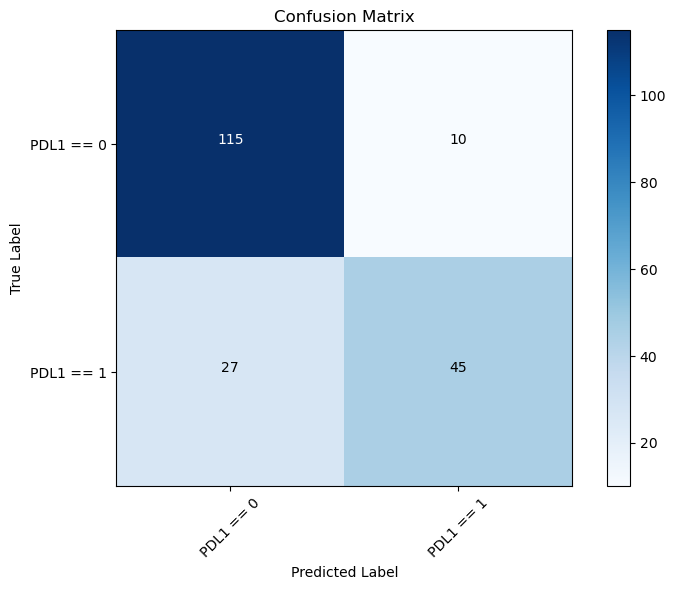

In [8]:
from sklearn.metrics import confusion_matrix
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')
y_pred_test = loaded_model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Add class labels to axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations for each cell
    thresh = cm.max() / 2  # Threshold for text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# # Example confusion matrix (computed earlier or loaded)
# cm_ex = np.array([
#     [50, 2, 1],
#     [5, 45, 3],
#     [2, 6, 40]
# ])

# Class names (optional, for labeling the axes)
class_names = ['PDL1 == 0', 'PDL1 == 1']

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_names)

## ResNet18: with Tensor Board + 46 Channels + with Dropout + ReduceLR + EarlyStopping + softmax + categorical cross entropy

### Callbacks

In [8]:
# Callbacks
log_dir = os.path.join("logs_ResNet50", "fit", "model_ResNet18_46_dropout_callbacks_f1_score_trained" + time.strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,   # Optimal patience value for validation accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="./models_ResNet/model_ResNet18_46_dropout_callbacks_f1_score_trained.keras", # save validation loss into file
        monitor="val_loss",  # monitor validation accuracy
        save_best_only=True,
    ),
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    min_lr=1.e-6,
    ), 
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

### One-Hot Encoding

In [9]:
#  Disable for F1_score / Sigmoid 
# One Hot Encoding
y_train= to_categorical(y_train)
y_val= to_categorical(y_val)
y_test = to_categorical(y_test)

### Network architecture

In [10]:
def identity_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet(shape = (32, 32, 3), classes = 10, block_layers = [3, 4, 6, 3], dropout_rate = 0.5):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = block_layers
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(2, activation = 'softmax')(x) # CHANGE HERE
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet18")
    return model

### Train Model

Change loss: 

    - categorical cross_entropy for softmax
    - binary cross_entropy for sigmoid

In [11]:
ROWS = 224; COLS = 224; CHANNELS = 46; CLASSES = 2; block_layers = [2,2,2,2] # ResNet18
dropout_rate = 0.5
# Build Network Graph 
model_ResNet18 = ResNet(shape = (ROWS, COLS, CHANNELS), classes = CLASSES, block_layers = block_layers, dropout_rate = dropout_rate)

# Compile Model 
l_rate = 1.e-4
opt = keras.optimizers.Adam(learning_rate=l_rate)
model_ResNet18.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"]) # Set threshold here
# [F1Score(threshold = 0.5, name = "f1_score")]
# Train Model 
batch = 64
epochs = 50
start_time = time.time()

history_ResNet18 = model_ResNet18.fit(X_train, y_train,
                                      epochs = epochs, batch_size = batch, 
                                      validation_data = (X_val, y_val), callbacks = callbacks_list)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time} seconds")

2024-12-17 20:27:11.512423: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5447106560 exceeds 10% of free system memory.
2024-12-17 20:27:14.123282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5447106560 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1734467245.857384  731931 service.cc:146] XLA service 0x7f4114004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734467245.857439  731931 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-17 20:27:26.115019: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 20:27:27.094336: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
2024-12-17 20:27:30.525386: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1734467270.441060  731931 device_compiler.h:188] Compiled cluster using XLA!  This line i

10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5658 - loss: 1.8393 - val_accuracy: 0.3655 - val_loss: 3.6623 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - accuracy: 0.6499 - loss: 1.1858 - val_accuracy: 0.3756 - val_loss: 2.4612 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - accuracy: 0.6730 - loss: 0.7471 - val_accuracy: 0.4010 - val_loss: 1.9207 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 744ms/step - accuracy: 0.6889 - loss: 0.7233 - val_accuracy: 0.5431 - val_loss: 0.9687 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 741ms/step - accuracy: 0.7400 - loss: 0.5873 - val_accuracy: 0.6548 - val_loss: 0.7549 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 737ms/step - accuracy: 0.7432 - loss: 0.5319 - val_accuracy: 0.6802 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - accuracy: 0.8311 - loss

### Testing Accuracy

In [12]:
# To load the model from file uncomment and run the following 
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_f1_score_trained.keras')
print("Test Accuracy is: {:.2f}%".format(loaded_model.evaluate(X_test, y_test)[1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.7913 - loss: 0.6654
Test Accuracy is: 0.79%


### Comments

Choosing binary cross_entropy and sigmoid seems to result in similar if not worse results than with softmax and cross_entropy